/Users/oliviajain/anaconda/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/Users/oliviajain/Desktop/DangerSense/darkflow_detection/darkflow/dark/darknet.py:54: UserWarning: ./cfg/yolov2.cfg not found, use cfg/yolo.cfg instead
  cfg_path, FLAGS.model))


Parsing cfg/yolo.cfg
Loading bin/yolov2.weights ...
Successfully identified 203934260 bytes
Finished in 1.2774441242218018s
Model has a coco model name, loading coco labels.

Building net ...
Source | Train? | Layer description                | Output size
-------+--------+----------------------------------+---------------
       |        | input                            | (?, 608, 608, 3)
 Load  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 608, 608, 32)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 304, 304, 32)
 Load  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 304, 304, 64)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 152, 152, 64)
 Load  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 152, 152, 128)
 Load  |  Yep!  | conv 1x1p0_1  +bnorm  leaky      | (?, 152, 152, 64)
 Load  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 152, 152, 128)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 76, 76, 128)
 Load  |  Yep!  | conv 3x3p1_1  +bno

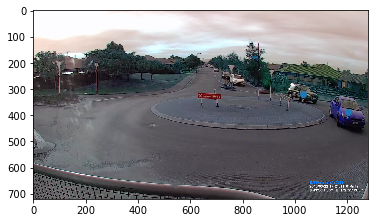

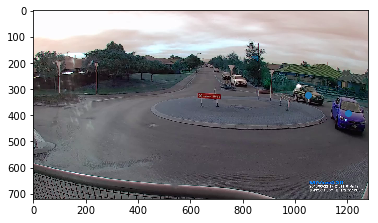

In [1]:
import os
import cv2
import time
import argparse
import multiprocessing
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import keras
from keras import backend as K
from keras.datasets import mnist, cifar10
from keras.models import Sequential, load_model, Model
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.optimizers import RMSprop, Adam, SGD
from keras.models import clone_model
from keras.callbacks import EarlyStopping
# from yolo_utils import *
from darkflow.net.build import TFNet
import re
import time
from sklearn.cluster import DBSCAN

class darkflow_prediction():

    def __init__(self):
        self.options = {"model": "cfg/yolo.cfg", "load": "bin/yolov2.weights", "threshold": 0.5}
        self.tfnet = TFNet(self.options)
        self.cluster = []

    def image(self, image_file):
        self.image = cv2.imread(image_file, 1)
        self.result = self.tfnet.return_predict(self.image)
        print(self.result)
        self.print_box()
        cv2.waitKey(0)

    def print_box(self):
        font = cv2.FONT_HERSHEY_PLAIN
        for i in range(len(self.result)):
            coordtl = (self.result[i]['topleft']['x'], self.result[i]['topleft']['y'])
            coordbr = (self.result[i]['bottomright']['x'], self.result[i]['bottomright']['y'])
            cv2.rectangle(self.image,coordtl,coordbr,(0,255,0),2)
            s = str(self.result[i]['label'] + ": " + str(self.result[i]['confidence']))
            text_coord = (coordtl[0], coordtl[1]-10)
            cv2.putText(self.image, s, text_coord, font, 1, (250,250,0))
        cv2.imshow("memes", self.image)

    def print_box_with_clusters(self, asd):
        font = cv2.FONT_HERSHEY_PLAIN
        for i in range(len(self.result)):
            coordtl = (self.result[i]['topleft']['x'], self.result[i]['topleft']['y'])
            coordbr = (self.result[i]['bottomright']['x'], self.result[i]['bottomright']['y'])
            cv2.rectangle(self.image,coordtl,coordbr,(0,255,0),2)
            s = str(self.result[i]['label'] + ": " + str(self.result[i]['confidence']))
            text_coord = (coordtl[0], coordtl[1]-10)
            cv2.putText(self.image, s, text_coord, font, 1, (250,250,0))
        for i, val in enumerate(asd):
            cv2.putText(self.image, str(val[1]), tuple(val[0]), font, 1, (250,250,0), 3)
        cv2.imshow("memes", self.image)

    def video(self, video_file):
        self.video = cv2.VideoCapture(video_file)
        results = []
        images = []
        interm, count = [], 1
        try:
            cluster_points = []
            asd = []
            while self.video.isOpened():
                ret, self.image = self.video.read()
                images.append(np.copy(self.image))
                self.result = self.tfnet.return_predict(self.image)
                results.append(self.result)
                for elem in self.result:
                    coordtl = (elem['topleft']['x'], elem['topleft']['y'])
                    coordbr = (elem['bottomright']['x'], elem['bottomright']['y'])
                    classif = elem['label']
                    confidence = elem['confidence']
                    width = coordbr[0] - coordtl[0]
                    height = coordbr[1] - coordtl[1]
                    x_center = coordtl[0] + width//2
                    y_center = coordtl[1] + height//2
                    new_elem = {'x': x_center, 'y': y_center, 'width': width,
                                'height': height, "class": classif, "confidence": confidence}
                    interm.append(new_elem)
                if count % 5 == 0:
                    cluster_points = []
                    for object_det in interm:
                        cluster_points.append([object_det['x'], object_det['y']])
                        model = DBSCAN(eps=100, min_samples=2).fit(np.array(cluster_points))
                        asd = [(cluster_points[i], model.labels_[i]) for i in range(len(cluster_points))]
                    interm = []
                count += 1
                self.print_box_with_clusters(asd)
                cv2.waitKey(1)
        except AssertionError:
            pass
        self.video_results_full = []
        for frame in results:
            new_frame = []
            for elem in frame:
                coordtl = (elem['topleft']['x'], elem['topleft']['y'])
                coordbr = (elem['bottomright']['x'], elem['bottomright']['y'])
                classif = elem['label']
                confidence = elem['confidence']
                width = coordbr[0] - coordtl[0]
                height = coordbr[1] - coordtl[1]
                x_center = coordtl[0] + width//2
                y_center = coordtl[1] + height//2
                new_elem = {'x': x_center, 'y': y_center, 'width': width,
                            'height': height, "class": classif, "confidence": confidence}
                new_frame.append(new_elem)
            self.video_results_full.append(new_frame)
        self.video_results_split = []
        interm, count = [], 1
        for elem in self.video_results_full:
            interm.append(elem)
            if count % 5 == 0:
                self.video_results_split.append(interm)
                interm = []
            count += 1
        print(self.video_results_full)
        print(len(self.video_results_full))
        print(self.video_results_split)
        print(len(self.video_results_split))
        self.group_grand_boxes = []
        for group in self.video_results_split:
            cluster_points = []
            for frame in group:
                for object_det in frame:
                    cluster_points.append([object_det['x'], object_det['y']])
            model = DBSCAN(eps=100, min_samples=2).fit(np.array(cluster_points))
            clusters = [(cluster_points[i], model.labels_[i]) for i in range(len(cluster_points))]
            clustered_points = {}
            for point in clusters:
                if point[1] not in clustered_points:
                    clustered_points[point[1]] = []
                clustered_points[point[1]].append((point[0][0], point[0][1]))
            grand_boxes = []
            for cluster_val in clustered_points:
                avgd_x, avgd_y = 0, 0
                for point in clustered_points[cluster_val]:
                    avgd_x += point[0]
                    avgd_y += point[1]
                avgd_x /= len(clustered_points[cluster_val])
                avgd_y /= len(clustered_points[cluster_val])
                width, height = 0, 0
                classif, confidence = '', ''
                for point in clustered_points[cluster_val]:
                    for frame in group:
                        for object_det in frame:
                            if object_det['x'] == point[0] and object_det['y'] == point[1]:
                                width += object_det['width']
                                height += object_det['height']
                                classif = object_det['class']
                                confidence = object_det['confidence']
                width /= len(clustered_points[cluster_val])
                height /= len(clustered_points[cluster_val])
                box = {'x': avgd_x, 'y': avgd_y, 'width': width,
                       'height': height, "class": classif, "confidence": confidence}
                grand_boxes.append(box)
            print(grand_boxes)
            self.group_grand_boxes.append(grand_boxes)
        print(self.group_grand_boxes)
        print(len(self.group_grand_boxes))
        count = 2
        for group in self.group_grand_boxes:
            x_points = [box['x'] for box in group]
            y_points = [box['y'] for box in group]
            plt.scatter(x_points, y_points)
            plt.imshow(images[count])
            plt.show()
            count += 5

    def video_with_frame_drop(self, video_file, FPS=30):
        self.video = cv2.VideoCapture(video_file)
        skip_frames = 0
        t = time.time()
        try:
            while self.video.isOpened():
                for i in range(skip_frames):
                    _, _ = self.video.read()
                ret, self.image = self.video.read()
                self.result = self.tfnet.return_predict(self.image)
                self.print_box()
                cv2.waitKey(1)
                skip_frames = int((time.time()-t)*FPS)
                t = time.time()
        except AssertionError:
            pass

pred = darkflow_prediction()
# pred.image("../cars2.jpg")
pred.video("../cars_video_min.mp4")


In [ ]:
from sklearn import linear_model

coordinates = [] # list of (x, y) coordinates 
predict()

def predict(): 
    regr = linear_model.LinearRegression()
    regr.fit(X_train, y_train)
    regr.predict(X)
    
    
    

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.layers import Embedding
from keras.layers import LSTM
import numpy as np

#assume we have a list of centroids (every 5 frames) for one object 

train = np.array([(1, 0), (1,0) , (1,0) , (1,0)])
test = train[.75*len(train):]

y_train = train[:.75*len(train)]
y_test = test

train_spec = train[:,6]
test_spec = test[:,6]


model = Sequential()
model.add(LSTM(32, input_shape=(1415684, 8)))
model.add(LSTM(64, input_dim=1, input_length=1415684, return_sequences=True))

model.add(Dropout(0.5))
model.add(Dense(1))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='rmsprop')

model.fit(train_spec, y_train, batch_size=2000, nb_epoch=11)
score = model.evaluate(test_spec, y_test, batch_size=2000)